# Overview of Assignment 2

This assignment explores fundamental concepts and techniques for image retrieval. The main objective is to develop an image retrieval system that efficiently searches a database to find visually similar images to a query image. This will involve implementing and comparing different feature extraction methods, similarity measures, and indexing structures covered in lectures.

#   Enter your details below

# Name

Mansi Patel

# Banner ID

B00871094

# Q1: Setting up the libraries and environment

In [11]:
!pip install numpy pandas matplotlib scikit-learn opencv-python-headless scikit-image tensorflow keras 

In [12]:
!pip install -qU \
  pinecone-client==3.1.0 \
  datasets

In [1]:
!pip install torch torchvision

## Import the usual libraries
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## print out the pytorch version used (1.31 at the time of this tutorial)
print(torch.__version__)
## configuration to detect cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

2.3.1+cpu
cpu


we'll preprocess the images to ensure they are in a suitable format for embedding generation. This may involve resizing the images to a consistent size, converting them to a specific color space (e.g., RGB), and normalizing the pixel values.

By the end of this step, we'll have our image dataset ready to be processed further and used in our search engine.

In [41]:
## configure root folder on your gdrive
# data_dir = 'gdrive/My Drive/dataset/hymenoptera_data'
data_dir = 'Vegetable Images'

## load the pretrained ResNet18 model
weights = models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

## load the correspoding folders
image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          transform=preprocess)

## load the dataset in batch_size of 32
data_loader = torch.utils.data.DataLoader(image_datasets,
                                            batch_size=32,
                                            shuffle=False)
img_paths = image_datasets.imgs
print(img_paths)

[('Vegetable Images\\train\\Bean\\0026.jpg', 0), ('Vegetable Images\\train\\Bean\\0028.jpg', 0), ('Vegetable Images\\train\\Bean\\0029.jpg', 0), ('Vegetable Images\\train\\Bean\\0030.jpg', 0), ('Vegetable Images\\train\\Bean\\0034.jpg', 0), ('Vegetable Images\\train\\Bean\\0035.jpg', 0), ('Vegetable Images\\train\\Bean\\0036.jpg', 0), ('Vegetable Images\\train\\Bean\\0037.jpg', 0), ('Vegetable Images\\train\\Bean\\0039.jpg', 0), ('Vegetable Images\\train\\Bean\\0041.jpg', 0), ('Vegetable Images\\train\\Bean\\0045.jpg', 0), ('Vegetable Images\\train\\Bean\\0047.jpg', 0), ('Vegetable Images\\train\\Bean\\0055.jpg', 0), ('Vegetable Images\\train\\Bean\\0058.jpg', 0), ('Vegetable Images\\train\\Bean\\0061.jpg', 0), ('Vegetable Images\\train\\Bean\\0063.jpg', 0), ('Vegetable Images\\train\\Bean\\0064.jpg', 0), ('Vegetable Images\\train\\Bean\\0065.jpg', 0), ('Vegetable Images\\train\\Bean\\0066.jpg', 0), ('Vegetable Images\\train\\Bean\\0067.jpg', 0), ('Vegetable Images\\train\\Bean\\0068.j

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7030813..1.8382572].


Dimension of images: torch.Size([32, 3, 224, 224]) 
 Dimension of labels: torch.Size([32])


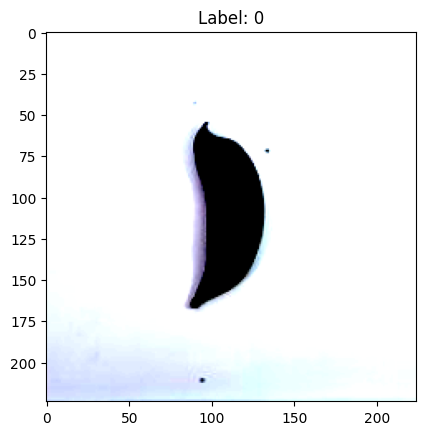

In [42]:
# Load the entire dataset in batches
data_iter = iter(data_loader)
x, y = next(data_iter)

# Print the dimensions of the images and labels
dim = x.shape[1]
print("Dimension of images:", x.shape, "\n",
      "Dimension of labels:", y.shape)

# Visualize one example from the batch
plt.imshow(x[0].permute(1, 2, 0).numpy())
plt.title(f"Label: {y[0].item()}")
plt.show()

# Q2: Feature Extraction

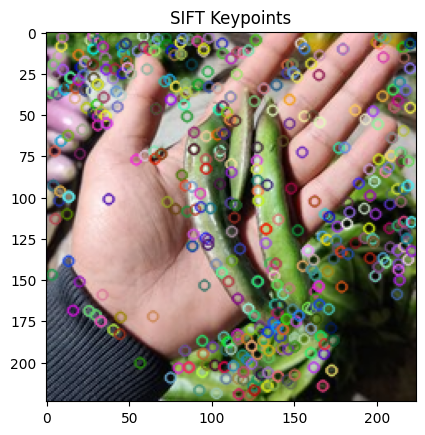

Number of SIFT keypoints detected: 477
Descriptor shape: (477, 128)


In [43]:
import cv2
import matplotlib.pyplot as plt

# Function to extract SIFT features
def extract_sift_features(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return image, keypoints, descriptors

# Function to visualize SIFT keypoints
def visualize_sift_keypoints(image, keypoints):
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
    plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title("SIFT Keypoints")
    plt.show()
    
train_dir = 'train'
class_dir = 'Bean'
img_name = '1351.jpg'
sample_img_path = os.path.join(data_dir, train_dir, class_dir, img_name)
image, keypoints, descriptors = extract_sift_features(sample_img_path)
visualize_sift_keypoints(image, keypoints)

print("Number of SIFT keypoints detected:", len(keypoints))
print("Descriptor shape:", descriptors.shape)


In [46]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Function to preprocess the image
def pre_process_img(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image

# Function to extract features
def extract_cnn_features(img_path):
    image = pre_process_img(img_path)
    features_conv_last = vgg16.features(image).detach()
    
    # Flatten the features to match the input shape of the classifier
    features_conv_last_flat = features_conv_last.view(features_conv_last.size(0), -1)
    features_fc = vgg16.classifier(features_conv_last_flat).detach()
    return features_conv_last, features_fc


base_dir = 'Vegetable Images'
train_dir = 'train'
class_dir = 'Bean'
img_name = '1351.jpg'
sample_img_path = os.path.join(base_dir, train_dir, class_dir, img_name)

features_conv_last, features_fc = extract_cnn_features(sample_img_path)

print("features from last convolutional layer:", features_conv_last)
print("features from last convolutional layer:", features_fc)

print("Shape of features from last convolutional layer:", features_conv_last.shape)
print("Shape of features from final fully connected layer:", features_fc.shape)


features from last convolutional layer: tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+

Last convolutional layer is better for differentiating images based on details due to spatial information and on the other hand Final Fully Connected Layeris better for categorizing images based on overall content due high-level representation.

# Q3 Similarity Measures


In [47]:
import numpy as np

# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

# Function to compute Euclidean distance
def euclidean_distance(vec1, vec2):
    distance = np.linalg.norm(vec1 - vec2)
    return distance


Query Image:


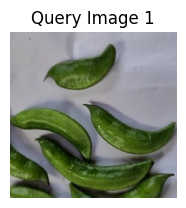

Top-K Similar Images (Cosine Similarity):


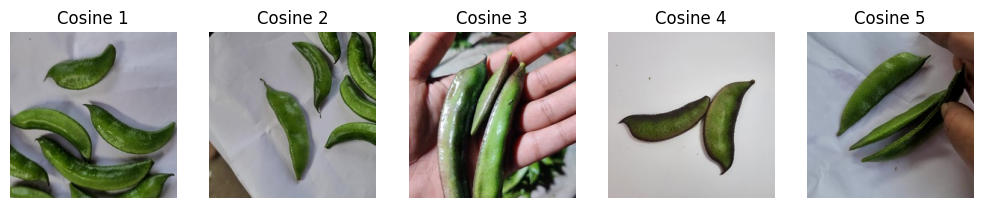

Top-K Similar Images (Euclidean Distance):


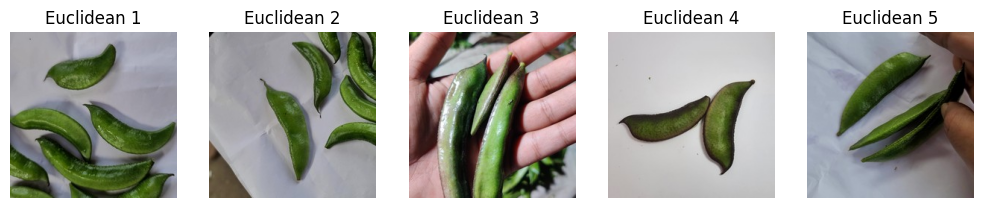

In [48]:
import matplotlib.pyplot as plt

# Select a subset of the dataset (e.g., first 300 images)
subset_size = 300
subset_indices = np.random.choice(len(image_datasets), subset_size, replace=False)

# Extract features for the subset of images
subset_features = []
subset_labels = []
subset_paths = []

for idx in subset_indices:
    img_path = image_datasets.imgs[idx][0]
    features_conv_last, features_fc = extract_cnn_features(img_path)
    subset_features.append(features_fc.squeeze().numpy())
    subset_labels.append(image_datasets.imgs[idx][1])
    subset_paths.append(img_path)

# Function to retrieve top-K similar images using a given similarity measure
def retrieve_top_k(query_features, subset_features, subset_paths, k, similarity_measure):
    similarities = []
    for features in subset_features:
        if similarity_measure == 'cosine':
            similarity = cosine_similarity(query_features, features)
        elif similarity_measure == 'euclidean':
            similarity = euclidean_distance(query_features, features)
        similarities.append(similarity)
    
    # Sort the similarities in descending order (for cosine) or ascending order (for euclidean)
    if similarity_measure == 'cosine':
        sorted_indices = np.argsort(similarities)[::-1]
    elif similarity_measure == 'euclidean':
        sorted_indices = np.argsort(similarities)
    
    top_k_indices = sorted_indices[:k]
    top_k_paths = [subset_paths[idx] for idx in top_k_indices]
    return top_k_paths

# Query image and its features
query_img_path = subset_paths[0]
query_features = subset_features[0]

# Retrieve top-K similar images
k = 5
top_k_cosine = retrieve_top_k(query_features, subset_features, subset_paths, k, 'cosine')
top_k_euclidean = retrieve_top_k(query_features, subset_features, subset_paths, k, 'euclidean')

# Display the query image and top-K similar images for both similarity measures
def display_images(img_paths, title):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path)
        plt.subplot(1, k + 1, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i + 1}")
        plt.axis('off')
    plt.show()

print("Query Image:")
display_images([query_img_path], "Query Image")

print("Top-K Similar Images (Cosine Similarity):")
display_images(top_k_cosine, "Cosine")

print("Top-K Similar Images (Euclidean Distance):")
display_images(top_k_euclidean, "Euclidean")



Cosine similarity 
1. Focuses on the angle between feature vectors, prioritizing overall pattern and structure.
2. Retrieved images have very similar color distribution and object presence to the query image.
3. Less sensitive to intensity and brightness variations.
Euclidean Distance
1. Considers the magnitude of feature vectors, accounting for minor differences in intensity and brightness.
2. More sensitive to exact pixel values.
3. Captures subtle intensity differences, useful when exact pixel values are significant.

# Q4 Image Retrieval Pipeline


In [49]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import os

def extract_sift_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a SIFT feature extractor
    sift = cv2.SIFT_create()
    
    # Detect and compute SIFT features
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    # print("keypoint :",keypoints)
    # print("descriptors :",descriptors)
    
    return descriptors

def cluster_features(features, k):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    
    # Get the cluster centers (visual words)
    visual_words = kmeans.cluster_centers_
    
    return visual_words



In [50]:
# Load images from the database
database_dir = 'Vegetable Images/train'
database_images = []
img_paths = []

for root, dirs, files in os.walk(database_dir):
    for file in files:
        if file.endswith(('jpg', 'jpeg', 'png')):
            img_path = os.path.join(root, file)
            image = cv2.imread(img_path)
            database_images.append(image)
            img_paths.append(img_path)

# Extract SIFT features from each image
database_descriptors = []
for image in database_images:
    descriptors = extract_sift_features(image)
    if descriptors is not None:
        database_descriptors.append(descriptors)

# Stack all descriptors into a single array
all_descriptors = np.vstack(database_descriptors)

In [14]:

# Convert to numpy array
all_descriptors = np.array(all_descriptors)

In [15]:
def cluster_features(features, k):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    # Get the cluster centers (visual words)
    visual_words = kmeans.cluster_centers_
    return kmeans, visual_words

# Number of clusters (visual words)
k = 100
kmeans, visual_words = cluster_features(all_descriptors, k)


In [18]:

from collections import defaultdict
def assign_visual_words(descriptors, kmeans):
    visual_word_ids = kmeans.predict(descriptors)
    return visual_word_ids

# Represent each image as a list of visual word IDs
image_visual_words = []

for img_path, descriptors in zip(img_paths, database_descriptors):
    visual_word_ids = assign_visual_words(descriptors, kmeans)
    image_visual_words.append((img_path, visual_word_ids))
query_img_path = 'Vegetable Images/train/Bean/1351.jpg'
query_descriptors = extract_sift_features(cv2.imread(query_img_path))
query_visual_word_ids = assign_visual_words(query_descriptors, kmeans)
# Create an inverted index
inverted_index = defaultdict(list)

for img_path, visual_word_ids in image_visual_words:
    for word_id in visual_word_ids:
        inverted_index[word_id].append(img_path)


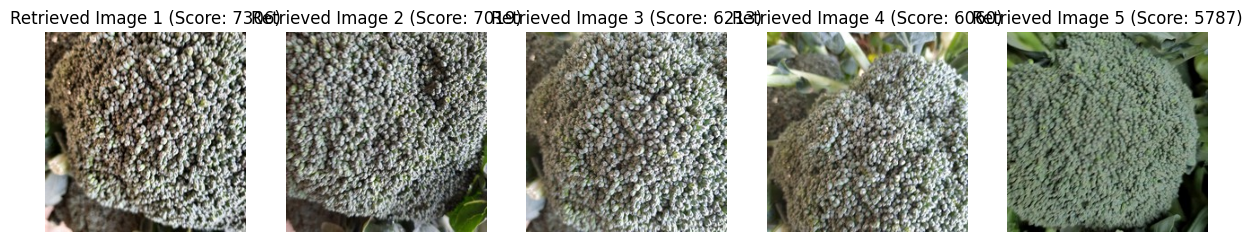

In [19]:
def retrieve_images(query_visual_word_ids, inverted_index):
    image_scores = defaultdict(int)

    for word_id in query_visual_word_ids:
        if word_id in inverted_index:
            for img_path in inverted_index[word_id]:
                image_scores[img_path] += 1
    
    # Sort images by score (term frequency)
    sorted_images = sorted(image_scores.items(), key=lambda item: item[1], reverse=True)
    return sorted_images

# Retrieve top-K results
k = 5
retrieved_images = retrieve_images(query_visual_word_ids, inverted_index)[:k]

# Display the top-K results
import matplotlib.pyplot as plt

def display_images(img_paths, title):
    plt.figure(figsize=(15, 5))
    for i, (img_path, score) in enumerate(img_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i + 1} (Score: {score})")
        plt.axis('off')
    plt.show()

display_images(retrieved_images, "Retrieved Image")


# Q5 Vector Database Integration

In [20]:
pip install pinecone-client


Note: you may need to restart the kernel to use updated packages.


In [21]:
import os
import getpass
from pinecone import Pinecone

api_key = 'c685e44d-8553-4623-9406-864e548095f9'
environment = 'us-east-1'
pc = Pinecone(api_key=api_key)

In [22]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [36]:
import time

index_name = "assignment-image-retrieval"

existing_indexes = [
    index_info["name"] for index_info in pc.list_indexes()
]

# check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=128,  # dimensionality of minilm
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [26]:
## configure root folder on your gdrive
# data_dir = 'gdrive/My Drive/dataset/hymenoptera_data'
data_dir = 'Vegetable Images'

## load the pretrained ResNet18 model
weights = models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

## load the correspoding folders
image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          transform=preprocess)

## load the entire dataset; we are not using minibatches here
data_loader = torch.utils.data.DataLoader(image_datasets,
                                            batch_size=32,
                                            shuffle=False)
img_paths = image_datasets.imgs
print(img_paths)
vectors = []
for j in range(len(image_datasets)):
    batch_features = extract_sift_features(cv2.imread(img_paths[j][0]))
    batch_features = batch_features.tolist()
    # labels = labels.tolist()

    for i in range(len(batch_features)):
        img_path = image_datasets.imgs[i][0]
        # print(img_path)
        vector = {
            "id": str(len(vectors)),
            "values": batch_features[i],
            "metadata": {         
                "image_url": img_path}
        }
        vectors.append(vector)


[('Vegetable Images\\train\\Bean\\0026.jpg', 0), ('Vegetable Images\\train\\Bean\\0028.jpg', 0), ('Vegetable Images\\train\\Bean\\0029.jpg', 0), ('Vegetable Images\\train\\Bean\\0030.jpg', 0), ('Vegetable Images\\train\\Bean\\0034.jpg', 0), ('Vegetable Images\\train\\Bean\\0035.jpg', 0), ('Vegetable Images\\train\\Bean\\0036.jpg', 0), ('Vegetable Images\\train\\Bean\\0037.jpg', 0), ('Vegetable Images\\train\\Bean\\0039.jpg', 0), ('Vegetable Images\\train\\Bean\\0041.jpg', 0), ('Vegetable Images\\train\\Bean\\0045.jpg', 0), ('Vegetable Images\\train\\Bean\\0047.jpg', 0), ('Vegetable Images\\train\\Bean\\0055.jpg', 0), ('Vegetable Images\\train\\Bean\\0058.jpg', 0), ('Vegetable Images\\train\\Bean\\0061.jpg', 0), ('Vegetable Images\\train\\Bean\\0063.jpg', 0), ('Vegetable Images\\train\\Bean\\0064.jpg', 0), ('Vegetable Images\\train\\Bean\\0065.jpg', 0), ('Vegetable Images\\train\\Bean\\0066.jpg', 0), ('Vegetable Images\\train\\Bean\\0067.jpg', 0), ('Vegetable Images\\train\\Bean\\0068.j

In [37]:
index.upsert(vectors[0:10])

{'upserted_count': 10}

References

https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
https://medium.com/analytics-vidhya/cnn-transfer-learning-with-vgg-16-and-resnet-50-feature-extraction-for-image-retrieval-with-keras-53320c580853
https://www.learndatasci.com/glossary/cosine-similarity/
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html